#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, best_alpha_Ridge, plot_RidgeCV, RidgeCV
import joblib
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=549dec98-e2a8-4f9a-8fbd-4d7706adefd3
To: /home/jupyter/IT_data.h5
100%|██████████| 384M/384M [00:02<00:00, 188MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
layers = ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]
layers = ["layer3"]

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 19/04/23 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, r2_score
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet, resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
import pickle
from tqdm import tqdm
import copy

# Fine-tune ResNet50 for classification of the images

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    val_acc_history = []
    model = model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize the losses for this epoch
            loss = 0.0
            corrects = 0
            
            steps_per_epoch_train = len(dataloaders['train'])
            steps_per_epoch_val = len(dataloaders['val'])
            
            for stimulus, label in dataloaders[phase]:
                stimulus, label = stimulus.cuda(), label.cuda()

                # zero out the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass (compute training loss)
                    prediction = model(stimulus)
                    loss = criterion(prediction, label)
                    
                    _, preds = torch.max(prediction, 1)

                    # Backward pass (compute new gradients, update weights))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update the loss for this epoch
                loss += loss.item() * stimulus.size(0)
                corrects += torch.sum(preds == label.data)

            epoch_loss = loss / len(dataloaders[phase].dataset)
            epoch_acc = corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
# Parameters
num_classes = len(np.unique(objects_train))
BATCH_SIZE = 10
EPOCHS = 40
LR = 0.001 

feature_extract = False # to finetune the model

# Datasets and dataloaders
le = preprocessing.LabelEncoder()

dataset_train = TensorDataset(torch.tensor(stimulus_train), torch.tensor(le.fit_transform(objects_train)))
dataset_val = TensorDataset(torch.tensor(stimulus_val), torch.tensor(le.fit_transform(objects_val)))
dataset_test = TensorDataset(torch.tensor(stimulus_test))
dataloaders = {'train' : DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE), 
               'val' : DataLoader(dataset_val, batch_size=BATCH_SIZE)}
testDataLoader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [7]:
# Initialize and reshape the model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
params_to_update = model.parameters()

# Create the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=LR, momentum=0.9)

In [8]:
# Fine-tune the model
model, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS)

Epoch 0/39
----------
train Loss: 0.0043 Acc: 0.1223
val Loss: 0.1027 Acc: 0.4375

Epoch 1/39
----------
train Loss: 0.0018 Acc: 0.5039
val Loss: 0.0251 Acc: 0.7153

Epoch 2/39
----------
train Loss: 0.0032 Acc: 0.7515
val Loss: 0.0166 Acc: 0.8229

Epoch 3/39
----------
train Loss: 0.0012 Acc: 0.8646
val Loss: 0.0041 Acc: 0.8750

Epoch 4/39
----------
train Loss: 0.0026 Acc: 0.9074
val Loss: 0.0121 Acc: 0.8542

Epoch 5/39
----------
train Loss: 0.0011 Acc: 0.9549
val Loss: 0.0079 Acc: 0.8889

Epoch 6/39
----------
train Loss: 0.0017 Acc: 0.9738
val Loss: 0.0006 Acc: 0.8993

Epoch 7/39
----------
train Loss: 0.0010 Acc: 0.9826
val Loss: 0.0037 Acc: 0.9062

Epoch 8/39
----------
train Loss: 0.0006 Acc: 0.9850
val Loss: 0.0014 Acc: 0.9306

Epoch 9/39
----------
train Loss: 0.0014 Acc: 0.9985
val Loss: 0.0034 Acc: 0.9514

Epoch 10/39
----------
train Loss: 0.0007 Acc: 0.9938
val Loss: 0.0009 Acc: 0.9097

Epoch 11/39
----------
train Loss: 0.0006 Acc: 0.9923
val Loss: 0.0008 Acc: 0.9097

Ep

In [9]:
# Save the model
torch.save(model.state_dict(), 'resnet50_finetuned.pt')

In [15]:
#En plus
def extract_activations2(self, stimuli) :
    """extract the activations of the model for the given stimuli

    Args:
        model (model): model we want to extract the activations from
        stimuli (ndarray): input data of the processed image's pixels

    Returns:
        list of ndarray: list of activations for each stimulus
    """    
    activations = []
    for x in stimuli : 
        x = self.conv1(x.unsqueeze(0))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
    return activations

ResNet.extract_activations2 = extract_activations2
activations_val2 = model.extract_activations2(torch.tensor(stimulus_val).cuda())

# Extract the activations and predict the neural activity

In [10]:
def extract_activations(self, stimuli, layer) :
    """extract the activations of the model for the given stimuli and layer

    Args:
        model (model): model we want to extract the activations from
        stimuli (ndarray): input data of the processed image's pixels

    Returns:
        dict: dictionary containing the activations for each layer of the model
    """    
    activations = []
    for x in stimuli : 
        x = self.conv1(x.unsqueeze(0))
        if layer == 'conv1' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if layer == 'layer1' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    
        x = self.layer2(x)
        if layer == 'layer2' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.layer3(x)
        if layer == 'layer3' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    
        x = self.layer4(x)
        if layer == 'layer4' :       
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.avgpool(x)
        if layer == 'avgpool' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    return activations

ResNet.extract_activations = extract_activations

In [11]:
# extract the activations of the layers and apply PCA on each layer to store the first 1000PCs
model.eval()
for layer in tqdm(layers) : 
    activations_train = model.extract_activations(torch.tensor(stimulus_train).cuda(), layer) 
    pca = PCA(n_components=1000)
    pca.fit(activations_train)  
    
    # Save the pca model of layer 3
    if layer == 'layer3' :
        joblib.dump(pca, 'pca_layer3.joblib')
    
    # Save the activations of the train, val and test set  
    with open(layer+'_train_W8.pkl','wb') as f:
        pickle.dump(pca.transform(activations_train), f)
    with open(layer+'_val_W8.pkl','wb') as f:
        pickle.dump(pca.transform(model.extract_activations(torch.tensor(stimulus_val).cuda(), layer)), f)
    with open(layer+'_test_W8.pkl','wb') as f:
        pickle.dump(pca.transform(model.extract_activations(torch.tensor(stimulus_test).cuda(), layer)), f)
        

100%|██████████| 1/1 [02:59<00:00, 179.50s/it]




R2 score for layer3 in function of the parameter alpha : 


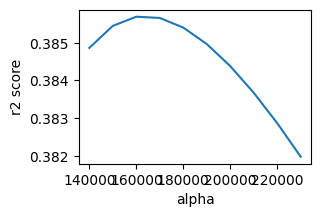

The best alpha is 160000


In [12]:
# Use the PCs of each layer to predict the neural activity using linear regression models
models = {}
best_alphas = {}
alphas = {'conv1' : [11000000, 11500000, 12000000, 12500000, 13000000, 13500000, 14000000,14500000, 15000000,15500000, 16000000], 
          'layer1' : [1600000, 1700000, 1800000, 1900000, 2000000, 2100000, 2200000, 2300000, 2400000, 2500000 ], 
          'layer2' : [400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000], 
          'layer3' : [140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000], 
          'layer4' : [400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000], 
          'avgpool' : [400,450,500, 550,600, 650, 700, 750, 800,850, 900, 950, 1000, 1050, 1100,]}

for layer in layers : 
    with open(layer+'_train_W8.pkl', 'rb') as f:
        activations_train = pickle.load(f)  
    print('\n\nR2 score for', layer, 'in function of the parameter alpha : ')
    models[layer], best_alphas[layer] = RidgeCV(activations_train, spikes_train, alphas[layer])
    
    # Save the model of layer 3
    if layer == 'layer3' :
        joblib.dump(models[layer], 'ridge_layer3.joblib')

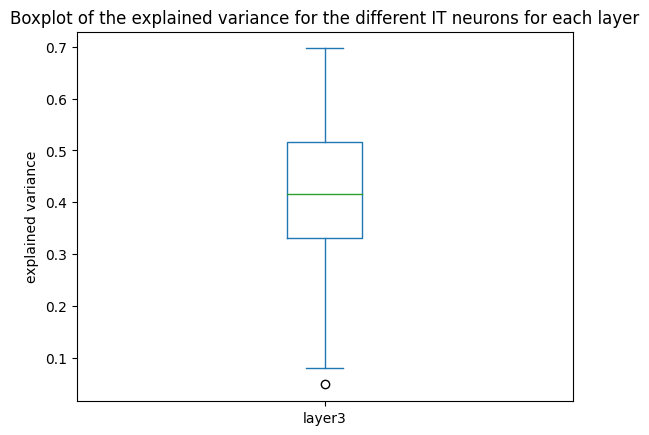

In [13]:
# Evaluate the models on the validation set
import pandas as pd
var = pd.DataFrame()
for layer in layers : 
    with open(layer+'_val_W8.pkl', 'rb') as f:
        activations_val = pickle.load(f)  
    var[layer] = explained_variance_score(spikes_val, models[layer].predict(activations_val), multioutput = 'raw_values')

var.plot(kind='box', title='Boxplot of the explained variance for the different IT neurons for each layer', ylabel='explained variance')
plt.show()

# Compare with layer3 activation of a randomly initialized resnet50



R2 score for the layer 3 of the scratch model in function of the parameter alpha : 


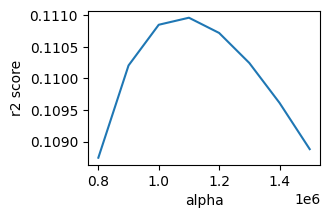

The best alpha is 1100000


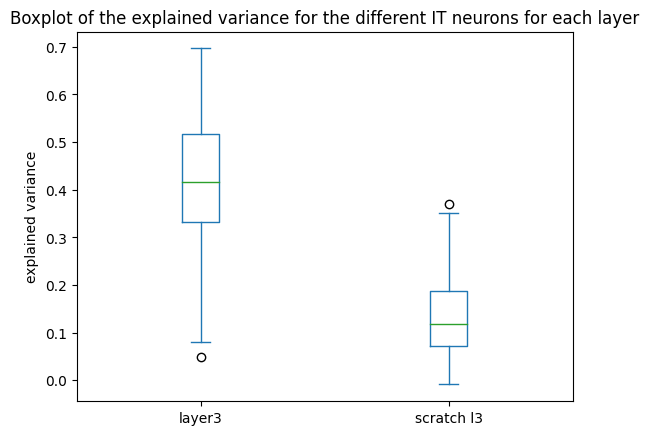

In [14]:
# Intialize model
model_scratch = resnet50(weights = None)

# Extract the activations and compute the PCs
activations_train = model_scratch.extract_activations(torch.tensor(stimulus_train), 'layer3')
pca = PCA(n_components=1000)
pca.fit(activations_train)    
with open('scratch_train_W7.pkl','wb') as f:
    pickle.dump(pca.transform(activations_train), f)
with open('scratch_val_W7.pkl','wb') as f:
    pickle.dump(pca.transform(model_scratch.extract_activations(torch.tensor(stimulus_val), 'layer3')), f)
    
# Predict the neural activity
alphas = [800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
with open('scratch_train_W7.pkl', 'rb') as f:
    activations_train = pickle.load(f)  
print('\n\nR2 score for the layer 3 of the scratch model in function of the parameter alpha : ')
ridge_scratch, best_alphas_scratch = RidgeCV(activations_train, spikes_train, alphas)

# Evaluate the model on the validation set
with open('scratch_val_W7.pkl', 'rb') as f:
    activations_val = pickle.load(f)  
var['scratch l3'] = explained_variance_score(spikes_val, ridge_scratch.predict(activations_val), multioutput = 'raw_values')
    
var.plot(kind='box', title='Boxplot of the explained variance for the different IT neurons for each layer', ylabel='explained variance')
plt.show()